### ***--> Installing the required libraries***

In [1]:
pip install pandas matplotlib seaborn prophet scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

### ***--> Loading Daily Data***

In [3]:
monthly_data = pd.read_csv("/content/SN_m_tot_V2.0.csv", delimiter=';', header=None)
monthly_data.columns = ["Year", "Month", "FractionalYear", "MonthlyMeanSunspotNumber", "StdDev", "Observations", "Indicator"]
monthly_data = monthly_data[monthly_data["MonthlyMeanSunspotNumber"] != -1]  # Remove missing values
monthly_data['Date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(Day=1))
monthly_data = monthly_data[['Date', "MonthlyMeanSunspotNumber"]].rename(columns={'Date': 'ds', "MonthlyMeanSunspotNumber": 'y'})

###***--> Preprocess the data***

In [4]:
monthly_data['y'] = monthly_data['y'] + 1  # Add small constant to handle zeros
monthly_data = monthly_data.dropna()  # Drop remaining invalid rows

###***--> Training the FBProphet Model***

In [5]:
# Initialize Prophet Model
monthly_model = Prophet()

# Fit the model
monthly_model.fit(monthly_data)

# Create future dataframe (9 months)
future_monthly = monthly_model.make_future_dataframe(periods=9, freq='M')

# Predict
forecast_monthly = monthly_model.predict(future_monthly)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0klzbgv2/qdolof2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0klzbgv2/c1meggj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85591', 'data', 'file=/tmp/tmp0klzbgv2/qdolof2d.json', 'init=/tmp/tmp0klzbgv2/c1meggj5.json', 'output', 'file=/tmp/tmp0klzbgv2/prophet_modelbmmgwcfq/prophet_model-20241127234056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:40:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:40:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


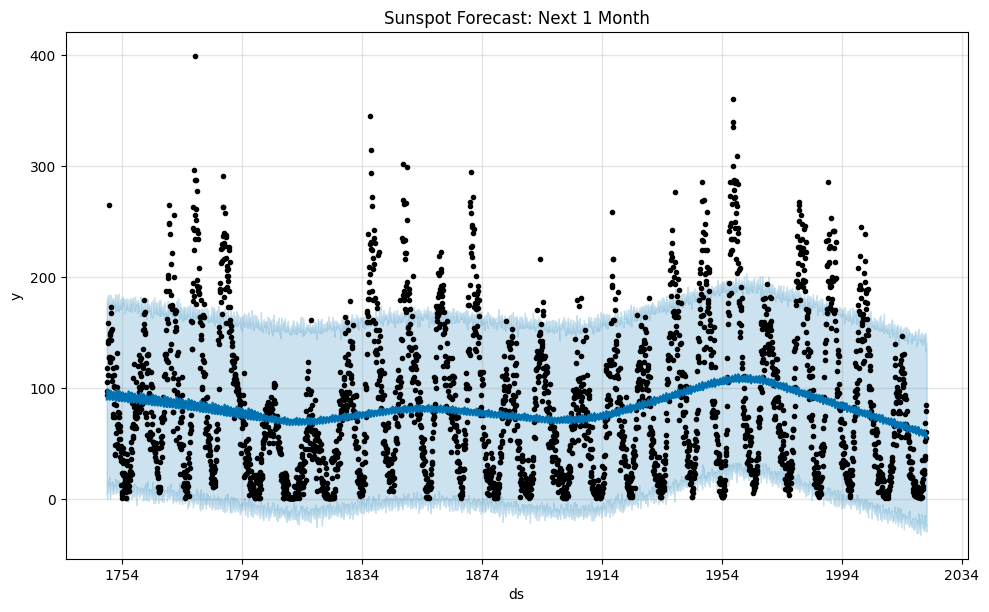

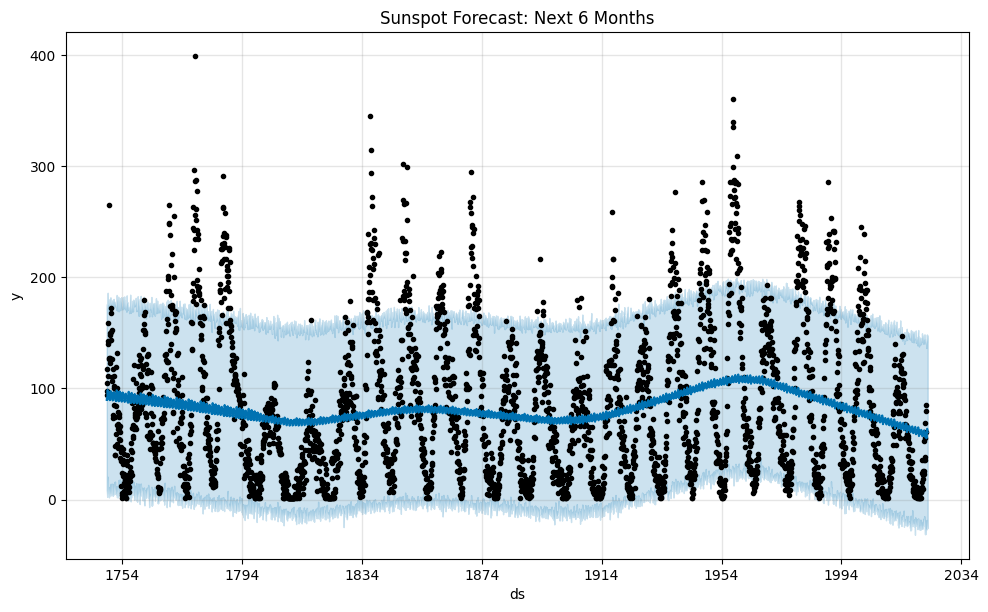

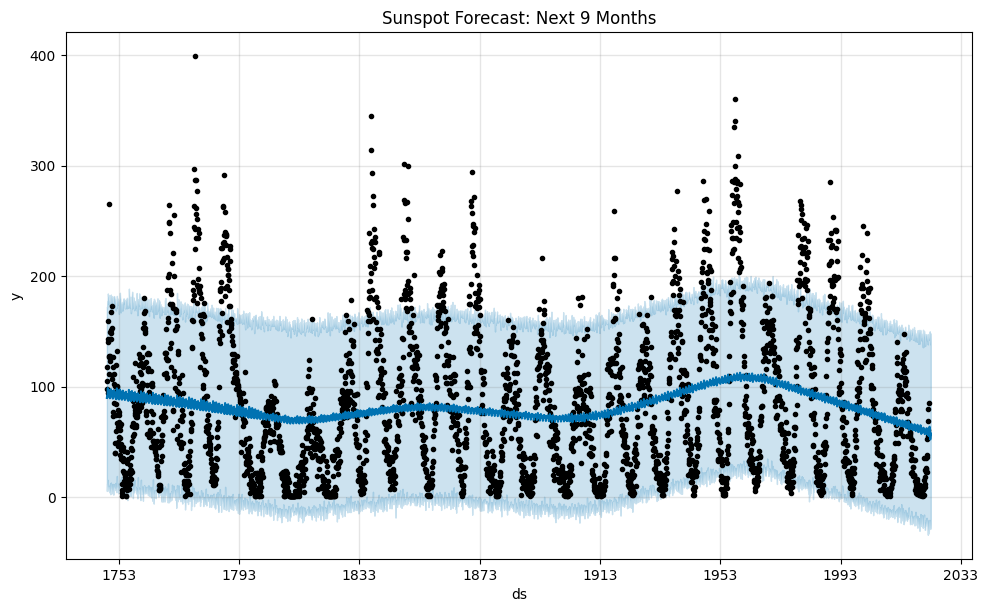

In [6]:
# Predict for 1, 6, and 9 months
future_monthly_1 = monthly_model.make_future_dataframe(periods=1, freq='M')
future_monthly_6 = monthly_model.make_future_dataframe(periods=6, freq='M')
future_monthly_9 = monthly_model.make_future_dataframe(periods=9, freq='M')

# Predict 1 month
forecast_monthly_1 = monthly_model.predict(future_monthly_1)

# Predict 6 months
forecast_monthly_6 = monthly_model.predict(future_monthly_6)

# Predict 9 months
forecast_monthly_9 = monthly_model.predict(future_monthly_9)

# Visualize predictions for each forecast
fig_1 = monthly_model.plot(forecast_monthly_1)
plt.title("Sunspot Forecast: Next 1 Month")
plt.show()

fig_6 = monthly_model.plot(forecast_monthly_6)
plt.title("Sunspot Forecast: Next 6 Months")
plt.show()

fig_9 = monthly_model.plot(forecast_monthly_9)
plt.title("Sunspot Forecast: Next 9 Months")
plt.show()

In [7]:
# For 1 month prediction
print("Predicted values for the next 1 month:")
print(forecast_monthly_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))

# For 6 months prediction
print("Predicted values for the next 6 months:")
print(forecast_monthly_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6))

# For 9 months prediction
print("Predicted values for the next 9 months:")
print(forecast_monthly_9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

Predicted values for the next 1 month:
             ds       yhat  yhat_lower  yhat_upper
3280 2022-04-30  55.113049  -29.496359  133.575787
Predicted values for the next 6 months:
             ds       yhat  yhat_lower  yhat_upper
3280 2022-04-30  55.113049  -27.027729  136.365974
3281 2022-05-31  59.104876  -22.906995  147.974828
3282 2022-06-30  60.775081  -18.409525  148.582565
3283 2022-07-31  63.640385  -23.168195  142.188445
3284 2022-08-31  60.755260  -25.367012  144.264180
3285 2022-09-30  60.452128  -25.701053  147.541755
Predicted values for the next 9 months:
             ds       yhat  yhat_lower  yhat_upper
3280 2022-04-30  55.113049  -32.928103  142.931643
3281 2022-05-31  59.104876  -23.974512  144.708211
3282 2022-06-30  60.775081  -20.759867  142.228688
3283 2022-07-31  63.640385  -20.891453  149.462502
3284 2022-08-31  60.755260  -22.445278  150.004754
3285 2022-09-30  60.452128  -25.497470  145.400273
3286 2022-10-31  52.114382  -28.809502  138.250197
3287 2022-11-3

###***--> Visualizing Predictions***

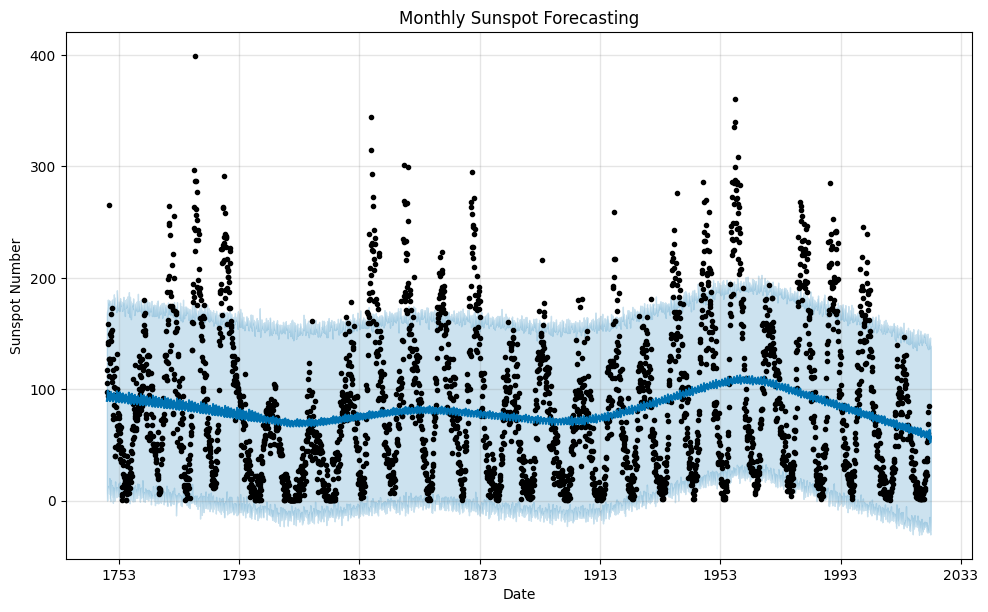

In [8]:
fig = monthly_model.plot(forecast_monthly)
plt.title("Monthly Sunspot Forecasting")
plt.xlabel("Date")
plt.ylabel("Sunspot Number")
plt.show()

### ***--> Tune Hyperparameters : Adding custom seasonality***

In [25]:
monthly_model = Prophet(
    growth='linear',                 # Linear growth for the trend
    changepoint_prior_scale=0.05,    # Restrict sensitivity to trend changes
    seasonality_prior_scale=10,      # Control the strength of seasonality
    seasonality_mode='multiplicative'  # Use multiplicative seasonality
)

# Adding custom seasonality to capture the solar cycle (~11 years in months)
monthly_model.add_seasonality(
    name='solar_cycle',
    period=12 * 11,  # ~11 years in months
    fourier_order=5  # Fourier order for capturing complex patterns
)
monthly_model.add_seasonality(
    name='half_solar_cycle',
    period=12 * 5.5 ,  # ~5.5 years in months
    fourier_order=3
)

# Fit and Predict again
monthly_model.fit(monthly_data)
forecast_monthly = monthly_model.predict(future_monthly)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0klzbgv2/8p1iefvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0klzbgv2/af3dkc_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59407', 'data', 'file=/tmp/tmp0klzbgv2/8p1iefvp.json', 'init=/tmp/tmp0klzbgv2/af3dkc_m.json', 'output', 'file=/tmp/tmp0klzbgv2/prophet_modeltow1iweu/prophet_model-20241127235033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:50:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:50:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


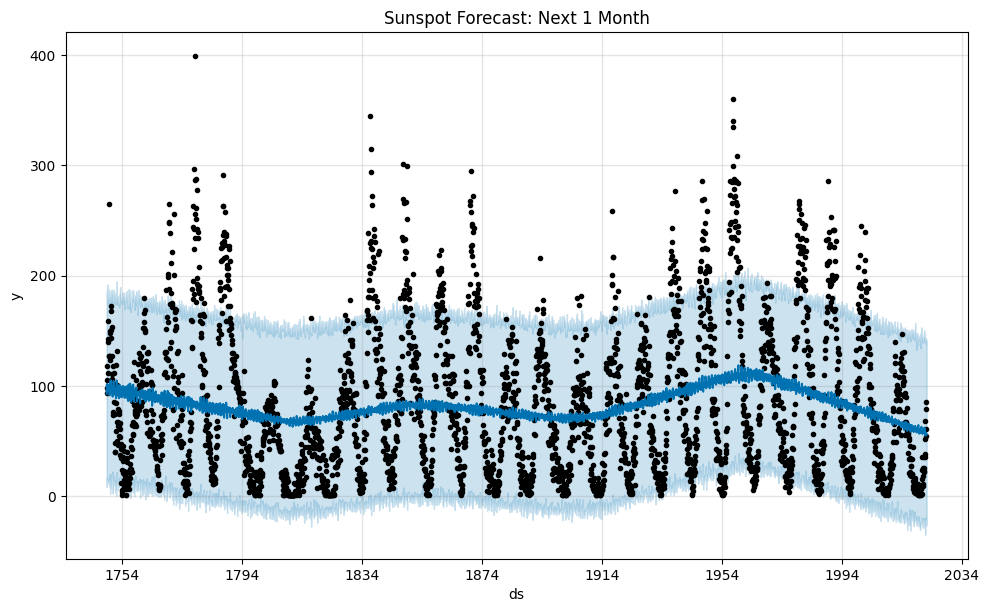

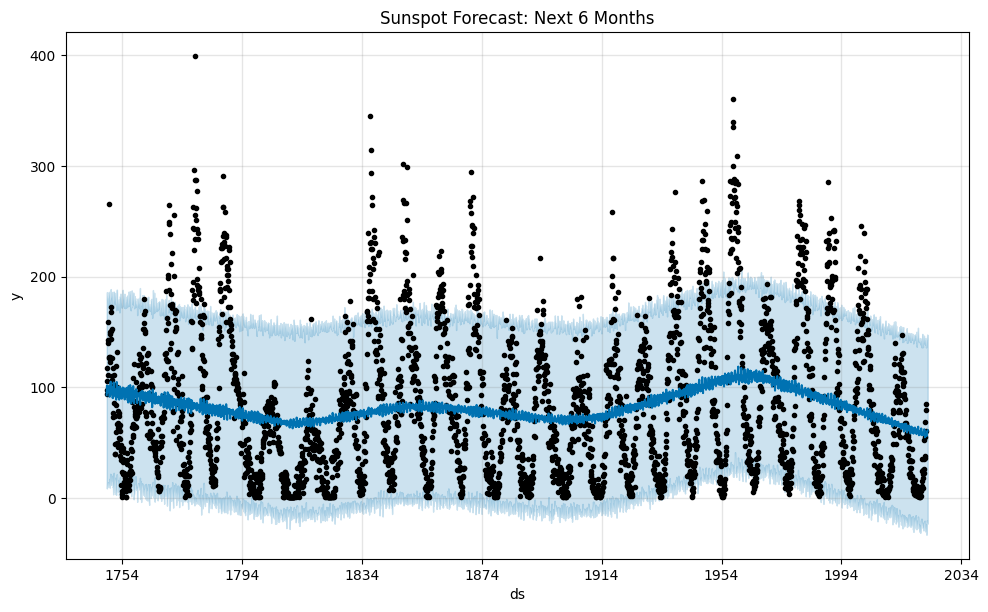

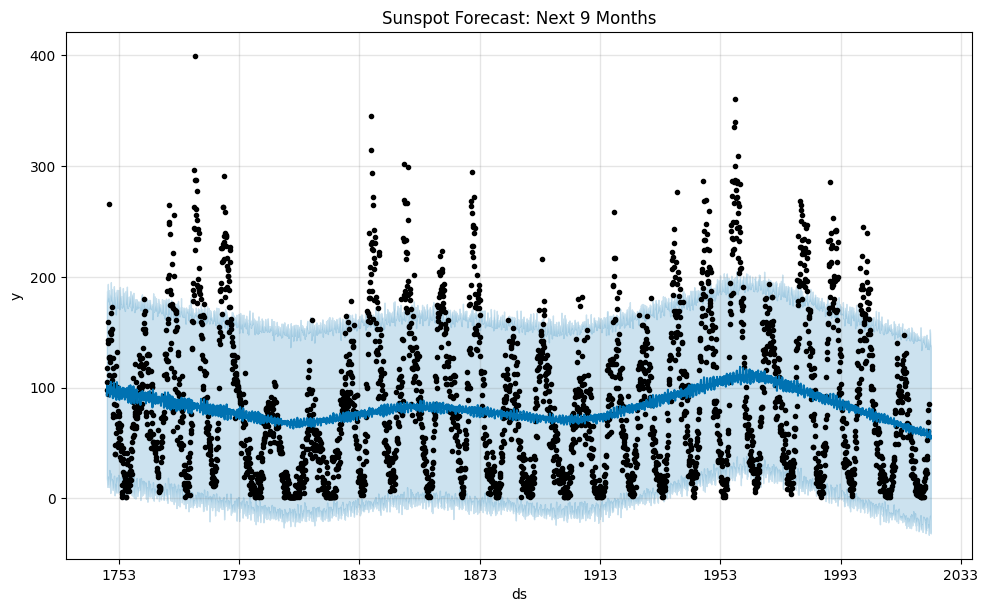

In [27]:
# Predict for 1, 6, and 9 months
future_monthly_1 = monthly_model.make_future_dataframe(periods=1, freq='M')
future_monthly_6 = monthly_model.make_future_dataframe(periods=6, freq='M')
future_monthly_9 = monthly_model.make_future_dataframe(periods=9, freq='M')

# Predict 1 month
forecast_monthly_1 = monthly_model.predict(future_monthly_1)

# Predict 6 months
forecast_monthly_6 = monthly_model.predict(future_monthly_6)

# Predict 9 months
forecast_monthly_9 = monthly_model.predict(future_monthly_9)

# Visualize predictions for each forecast
fig_1 = monthly_model.plot(forecast_monthly_1)
plt.title("Sunspot Forecast: Next 1 Month")
plt.show()

fig_6 = monthly_model.plot(forecast_monthly_6)
plt.title("Sunspot Forecast: Next 6 Months")
plt.show()

fig_9 = monthly_model.plot(forecast_monthly_9)
plt.title("Sunspot Forecast: Next 9 Months")
plt.show()

In [28]:
# For 1 month prediction
print("Predicted values for the next 1 month:")
print(forecast_monthly_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))

# For 6 months prediction
print("Predicted values for the next 6 months:")
print(forecast_monthly_6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6))

# For 9 months prediction
print("Predicted values for the next 9 months:")
print(forecast_monthly_9[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9))

Predicted values for the next 1 month:
             ds       yhat  yhat_lower  yhat_upper
3280 2022-04-30  55.977188  -23.343105  140.756225
Predicted values for the next 6 months:
             ds       yhat  yhat_lower  yhat_upper
3280 2022-04-30  55.977188  -33.086528  139.843903
3281 2022-05-31  56.133243  -31.385171  142.885857
3282 2022-06-30  58.620706  -19.976213  143.640439
3283 2022-07-31  60.216127  -21.708807  147.738090
3284 2022-08-31  60.033569  -22.220354  142.815041
3285 2022-09-30  61.215993  -23.007694  146.826613
Predicted values for the next 9 months:
             ds       yhat  yhat_lower  yhat_upper
3280 2022-04-30  55.977188  -32.860768  134.607181
3281 2022-05-31  56.133243  -27.622601  140.020640
3282 2022-06-30  58.620706  -25.628751  140.290180
3283 2022-07-31  60.216127  -19.948414  143.237758
3284 2022-08-31  60.033569  -18.107387  152.463029
3285 2022-09-30  61.215993  -15.714011  149.247717
3286 2022-10-31  54.281682  -30.615067  140.539024
3287 2022-11-3

###***--> Evaluating Model Performance***

In [26]:
# Evaluate using proper y_true and y_pred alignment
y_true = monthly_data['y']
y_pred = forecast_monthly['yhat'][:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.3f}")

MAE: 53.22, MAPE: 4.18, R²: 0.069
